In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

import pandas as pd
import load_data
import LFP
from joblib import Parallel, delayed
import h5py

from scipy.signal import find_peaks
import pickle

C:\Users\ML_4\anaconda3\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
class RippleDataset:
    
    def __init__(self, h5_path):
        self.f = h5py.File(h5_path, 'r')
        self.band_sig = self.f['band_sig']
        self.power = self.f['power']
        self.zscored = self.f['zscored']
        self.peaks = self.f['peaks']

    def get_trace(self, time):
        return {
            'band_sig': self.band_sig[time, :],
            'power': self.power[time, :],
            'zscored': self.zscored[time, :],
        }

    def get_band_sig(self, time):
        if len(time)==0:
            return self.band_sig[:]
        else:
            return self.band_sig[time, :]

    def get_power(self, time):
        if len(time)==0:
            return self.power[:]
        else:
            return self.power[time, :]

    def get_zscored(self, time):
        if len(time)==0:
            return self.zscored[:]
        else:
            return self.zscored[time, :]
    
    def get_peaks(self):
        peaks_grp = self.peaks
        names = sorted(peaks_grp.keys(), key=lambda x: int(x[2:]))
        all_peaks = []
        for ch in names:
            all_peaks.append(peaks_grp[ch][:]) 
        return all_peaks

    def close(self):
        self.f.close()


In [3]:
class RippleDataset2:
    
    def __init__(self, h5_path):
        self.f = h5py.File(h5_path, 'r')
        self.timestamps = self.f['timestamps']
        self.band_sig = self.f['band_sig']
        self.power = self.f['power']
        self.power_z = self.f['power_z']

    def get_trace(self, time):
        return {
            'band_sig': self.band_sig[time, :],
            'power': self.power[time, :],
            'power_z': self.power_z[time,:]
        }

    def get_band_sig(self, time, channel):
        return self.band_sig[time, :][:,channel]

    def get_power(self, time, channel):
        return self.power[time, :][:,channel]

    def get_power_z(self,time, channel):
        return self.power_z[time,:][:,channel]

    def close(self):
        self.f.close()


In [4]:
def identify_ripple(date,probes,zscore_th=30):
    
    ds = RippleDataset("D:/SWR/Session_%s_ripples_80_180.h5" % date)
    SWR_peaks = ds.get_peaks()
    ds.close()
    
    timestamps, lfpData = load_data.load_LFP(date)
    ds2 = RippleDataset2("D:/SWR/Session_%s_RippleBand_80_180.h5" % date)
    
    nchannels = lfpData.shape[1]
    ripple_peak = np.zeros(lfpData.shape)
    ripple_dur = np.zeros(lfpData.shape)
    
    for ii in range(nchannels):
        
        if len(SWR_peaks[ii])>0:
            
            ripple_peak[SWR_peaks[ii][:,0].astype(int),ii]=1
            
            for row in SWR_peaks[ii]:
                
                start = int(row[1])
                end   = int(row[2])
                ripple_dur[start:end, ii] = 1    # mark the entire duration from ripple on to ripple off as 1
    
    channels_detected = ripple_dur.sum(axis=1)
    
    # get ripple dataframe, label each ripple with number of channels detected 
    
    ripple_exist = 1*(channels_detected>0)
    ripple_starts = np.where(np.diff(ripple_exist)==1)[0]
    ripple_stops = np.where(np.diff(ripple_exist)==-1)[0]
    
    detected_channels = np.zeros((len(ripple_starts),len(probes)))
    outlier_channels = np.zeros((len(ripple_starts),len(probes)))
    
    for ii in range(len(ripple_starts)):
    
        chunk = ripple_dur[ripple_starts[ii]:ripple_stops[ii],:]

        for jj, p in enumerate(probes.probe.unique()):

            sub_df = probes.query('probe==@p')
            p_channels = np.arange(sub_df.start_channel.min()-1, sub_df.end_channel.max())
            detected_channels[ii,jj] = chunk[:,p_channels].sum(axis=1).max()
            band_chunk = ds2.get_power_z(np.arange(ripple_starts[ii],ripple_stops[ii]),p_channels)
            outlier_channels[ii,jj] = np.sum(np.sum(band_chunk>zscore_th,axis=0)>0)

    regions = probes.region.values
    subfields = probes.subfield.values

    if np.sum(subfields=='CA1')==0:
        CA1_channels = np.nan
    else:
        CA1_channels = detected_channels[:,subfields=='CA1'].sum(axis=1)

    if np.sum(subfields=='CA3')==0:
        CA3_channels = np.nan
    else:
        CA3_channels = detected_channels[:,subfields=='CA3'].sum(axis=1)

    if np.sum(subfields=='RAD')==0:
        RAD_channels = np.nan
    else:
        RAD_channels = detected_channels[:,subfields=='RAD'].sum(axis=1)
    
    ripple_channel = pd.DataFrame(data={
        'rippleID': np.arange(len(ripple_starts)),
        'on': ripple_starts,
        'off': ripple_stops,
        'dur': ripple_stops - ripple_starts,
        'ofc_channels': detected_channels[:,regions=='OFC'].sum(axis=1),
        'hpc_channels': detected_channels[:,regions=='HPC'].sum(axis=1),
        'CA1_channels': CA1_channels,
        'CA3_channels': CA3_channels,
        'RAD_channels': RAD_channels,
        'detected_channels': list(detected_channels),
        'outlier_channels': list(outlier_channels),
        'ofc_outlier': np.sum(outlier_channels[:,regions=='OFC']>16,axis=1)==3,
        'hpc_outlier': np.sum(outlier_channels[:,regions=='HPC']>16,axis=1)==p-3
    })

    return ripple_channel

In [5]:
def get_trial_ripple_rate(peaks,df):
    
    starts = df.start_time.values
    stops = df.stop_time.values
    counts = np.zeros(len(df))
    rates = np.zeros(len(df))
    
    for tt in range(len(df)):
        rel_onset = (peaks>starts[tt]) & (peaks<stops[tt])
        if len(rel_onset)>0:
            counts[tt] = rel_onset.sum()
            rates[tt] = rel_onset.sum()/(stops[tt]-starts[tt])*1000
    
    return counts, rates

In [6]:
def get_ripple_vals(block_df, col, n=6):
    
    if col not in block_df.columns:
        return np.nan

    vals = block_df[col].values[:n]

    if len(vals) < n:
        vals = np.pad(vals, (0, n - len(vals)), constant_values=np.nan)

    return vals

In [5]:
date = '031723'

# --- load trials ---
nwbfile = load_data.load_nwbfile('Bart', date)
trial_df = nwbfile.intervals['trials'].to_dataframe()
trial_df = trial_df.iloc[:, :-1]   # drop last column

# --- load ripple data ---
unitNames = nwbfile.units.to_dataframe()
probes = unitNames.drop_duplicates('probe')
ripple_df = identify_ripple(date,probes).query('~ofc_outlier & ~hpc_outlier')

In [195]:
# first ripple

dates = ['031723','032023','032823','033123','040423','040723']
rows = []

for date in dates:
    
    # --- load trials ---
    nwbfile = load_data.load_nwbfile('Bart', date)
    trial_df = nwbfile.intervals['trials'].to_dataframe()
    trial_df = trial_df.iloc[:, :-1]   # drop last column
    
    # --- load ripple data ---
    unitNames = nwbfile.units.to_dataframe()
    probes = unitNames.drop_duplicates('probe')
    ripple_df = identify_ripple(date,probes).query('~ofc_outlier & ~hpc_outlier')

    # --- ripple counts per trial ---
    OFC_peaks = ripple_df.query('ofc_channels > 0').on.values
    OFC_counts, _ = get_trial_ripple_rate(OFC_peaks, trial_df)

    HPC_peaks = ripple_df.query('hpc_channels > 0').on.values
    _, HPC_counts = get_trial_ripple_rate(HPC_peaks, trial_df)        

    trial_df['OFC_ripple'] = OFC_counts
    trial_df['HPC_ripple'] = HPC_counts
    
    if np.isnan(ripple_df['CA1_channels']).mean():
        trial_df['CA1_ripple'] = np.nan
    else:
        peaks = ripple_df.query('CA1_channels > 0').on.values
        _, counts = get_trial_ripple_rate(peaks, trial_df)   
        trial_df['CA1_ripple'] = counts
        

    if np.isnan(ripple_df['CA3_channels']).mean():
        trial_df['CA3_ripple'] = np.nan
    else:
        peaks = ripple_df.query('CA3_channels > 0').on.values
        _, counts = get_trial_ripple_rate(peaks, trial_df)  
        trial_df['CA3_ripple'] = counts
        

    if np.isnan(ripple_df['RAD_channels']).mean():
        trial_df['RAD_ripple'] = np.nan
    else:
        peaks = ripple_df.query('RAD_channels > 0').on.values
        _, counts = get_trial_ripple_rate(peaks, trial_df)  
        trial_df['RAD_ripple'] = counts

            
    trial_df.dropna(axis=1, inplace=True)
    action_df = nwbfile.intervals['action_on'].to_dataframe()
    start = action_df.query('step==0').copy()
    start['performance'] = start.nsteps - start.graph_distance
        
    for block, block_df in trial_df.groupby('block'):
        
        block = int(block)
    
        # first OFC ripple index
        idx = np.where(block_df.OFC_ripple.values > 0)[0]
        first_OFC = idx.min()+1 if len(idx) > 0 else np.nan

        perf = start.query('block==@block').performance.values
    
        if len(perf)<6:
            perf = np.pad(perf, (0, 6 - len(perf)), constant_values=np.nan)
        else:
            perf = perf[:6]

        
        rows.append({
            'date': date,
            'block': block,
            'first_OFC': first_OFC,
            'HPC_ripples': get_ripple_vals(block_df, 'HPC_ripple'),
            'CA1_ripples': get_ripple_vals(block_df, 'CA1_ripple'),
            'CA3_ripples': get_ripple_vals(block_df, 'CA3_ripple'),
            'RAD_ripples': get_ripple_vals(block_df, 'RAD_ripple'),
            'performance': perf
        })

# --- final dataframe ---
df = pd.DataFrame(rows)


In [80]:
# accumulative ripples in a block

dates = ['031723','032023','032823','033123','040423','040723']
all_trial_df = pd.DataFrame()

for date in dates:
    
    # --- load trials ---
    nwbfile = load_data.load_nwbfile('Bart', date)
    trial_df = nwbfile.intervals['trials'].to_dataframe()
    trial_df = trial_df.iloc[:, :-1]   # drop last column
    
    # --- load ripple data ---
    unitNames = nwbfile.units.to_dataframe()
    probes = unitNames.drop_duplicates('probe')
    ripple_df = identify_ripple(date,probes).query('~ofc_outlier & ~hpc_outlier')

    # --- ripple counts per trial ---
    OFC_peaks = ripple_df.query('ofc_channels > 0').on.values
    OFC_counts, _ = get_trial_ripple_rate(OFC_peaks, trial_df)

    HPC_peaks = ripple_df.query('hpc_channels > 0').on.values
    HPC_counts, _ = get_trial_ripple_rate(HPC_peaks, trial_df)        

    trial_df['OFC_ripple'] = OFC_counts
    trial_df['HPC_ripple'] = HPC_counts
    
    # if np.isnan(ripple_df['CA1_channels']).mean():
    #     trial_df['CA1_ripple'] = np.nan
    # else:
    #     peaks = ripple_df.query('CA1_channels > 0').on.values
    #     counts,_ = get_trial_ripple_rate(peaks, trial_df)   
    #     trial_df['CA1_ripple'] = counts
        

    # if np.isnan(ripple_df['CA3_channels']).mean():
    #     trial_df['CA3_ripple'] = np.nan
    # else:
    #     peaks = ripple_df.query('CA3_channels > 0').on.values
    #     counts,_ = get_trial_ripple_rate(peaks, trial_df)  
    #     trial_df['CA3_ripple'] = counts
        

    # if np.isnan(ripple_df['RAD_channels']).mean():
    #     trial_df['RAD_ripple'] = np.nan
    # else:
    #     peaks = ripple_df.query('RAD_channels > 0').on.values
    #     counts,_ = get_trial_ripple_rate(peaks, trial_df)  
    #     trial_df['RAD_ripple'] = counts

            
    # action_df = nwbfile.intervals['action_on'].to_dataframe().query('trialerror<2')
    # start = action_df.query('step==0').copy()
    # start['performance'] = start.nsteps - start.graph_distance
        
    # trial_df = trial_df.query('trialerror<2')
    
    # ofc_ripples = []
    # hpc_ripples = []
    # all_perf = []
    
    # for block, block_df in trial_df.groupby('block'):
        
    #     block = int(block)
    #     ofc_ripples.append(np.r_[0,np.cumsum(block_df.OFC_ripple.values)[:-1]])
    #     hpc_ripples.append(np.r_[0,np.cumsum(block_df.HPC_ripple.values)[:-1]])
    
    #     perf = start.query('block==@block').performance.values
    #     all_perf.append(perf)
    
    # trial_df['acc_ofc_ripples']=np.concat(ofc_ripples)
    # trial_df['acc_hpc_ripples']=np.concat(hpc_ripples)
    # trial_df['performance'] = np.concat(all_perf)

    all_trial_df = pd.concat([all_trial_df,trial_df])


In [8]:
# accumulative ripples in a block, 2

dates = ['031723','032023','032823','033123','040423','040723']
all_trial_df = pd.DataFrame()

for date in dates:
    
    # --- load trials ---
    nwbfile = load_data.load_nwbfile('Bart', date)
    trial_df = nwbfile.intervals['trials'].to_dataframe().query('trialerror<2')
    trial_df = trial_df.iloc[:, :-1]   # drop last column

    action_df = nwbfile.intervals['action_on'].to_dataframe().query('trialerror<2')
    start = action_df.query('step==0').copy()
    trial_df['performance'] = start.nsteps.values - start.graph_distance.values
    
    # --- load ripple data ---
    unitNames = nwbfile.units.to_dataframe()
    probes = unitNames.drop_duplicates('probe')
    ripple_df = identify_ripple(date,probes).query('~ofc_outlier & ~hpc_outlier')

    # --- ripple counts per trial ---
    OFC_peaks = ripple_df.query('ofc_channels > 0').on.values
    OFC_counts = cumulative_ripple(OFC_peaks, trial_df)

    HPC_peaks = ripple_df.query('hpc_channels > 0').on.values
    HPC_counts = cumulative_ripple(HPC_peaks, trial_df)        

    trial_df['OFC_ripple'] = OFC_counts
    trial_df['HPC_ripple'] = HPC_counts

    if np.isnan(ripple_df['CA1_channels']).mean():
        trial_df['CA1_ripple'] = np.nan
    else:
        peaks = ripple_df.query('CA1_channels > 0').on.values
        counts = cumulative_ripple(peaks, trial_df)   
        trial_df['CA1_ripple'] = counts
        

    if np.isnan(ripple_df['CA3_channels']).mean():
        trial_df['CA3_ripple'] = np.nan
    else:
        peaks = ripple_df.query('CA3_channels > 0').on.values
        counts = cumulative_ripple(peaks, trial_df)  
        trial_df['CA3_ripple'] = counts

    
    all_trial_df = pd.concat([all_trial_df,trial_df])


In [9]:
ses_info = pd.DataFrame({
    'session': ['031723','032823','033123','032023','040423','040723'],
    'animal': ['Bart']*6
})

    
action_all = pd.DataFrame()

for _, row in ses_info.iterrows():
    date = row['session']
    animal = row['animal']

    nwbfile = load_data.load_nwbfile(animal, date)

    action_df = (
        nwbfile.intervals['action_on']
        .to_dataframe()
        .query('trialerror==0')
        .copy()
    )

    # add metadata (very important)
    action_df['session'] = date
    action_df['animal'] = animal

    action_all = pd.concat([action_all,action_df])

action_all = action_all.drop(columns=['timeseries'])

first = action_all.query('step==0').copy()
first['trial_in_block'] = (
    first
    .groupby(['session', 'block'])
    .cumcount()
)

block_targets = (
    first
    .drop_duplicates(subset=['session', 'block'])
    [['session', 'block', 'target']]
)

block_targets['prev_block_target'] = (
    block_targets
    .groupby('session')['target']
    .shift(1)
)

first = first.merge(
    block_targets[['session', 'block', 'prev_block_target']],
    on=['session', 'block'],
    how='left'
)

first['optimality'] = first['graph_distance']/first['nsteps']
first['extra'] = first['nsteps']-first['graph_distance']

In [81]:
nav = all_trial_df.query('trialerror==0').copy()
nav['prev_block_target'] = first['prev_block_target'].values
nav['extra'] = first['extra'].values
nav['trial_in_block'] = first['trial_in_block'].values

In [82]:
mean_ = nav.query('trial_in_block==0').groupby(['prev_block_target','target'])[['extra','HPC_ripple','OFC_ripple']].mean().reset_index()

In [97]:
import statsmodels.api as sm

X = nav.query('(trial_in_block==0)&(OFC_ripple<5)')['OFC_ripple'].values
y = nav.query('(trial_in_block==0)&(OFC_ripple<5)')['extra']

X = sm.add_constant(X)   # adds intercept

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  extra   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.326
Date:                Sun, 28 Dec 2025   Prob (F-statistic):              0.128
Time:                        00:27:36   Log-Likelihood:                -1320.0
No. Observations:                 741   AIC:                             2644.
Df Residuals:                     739   BIC:                             2653.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2555      0.082      3.120      0.0

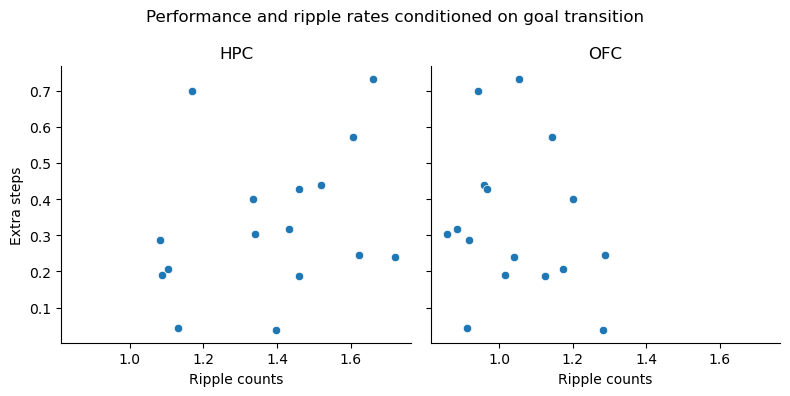

In [98]:
plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)

mean_ = nav.query('trial_in_block==0').groupby(['prev_block_target','target'])[['extra','HPC_ripple','OFC_ripple']].mean().reset_index()

sns.scatterplot(data=mean_,x='HPC_ripple',y='extra',ax=axes[0])
axes[0].set_title('HPC')
axes[0].set_ylabel('Extra steps')
axes[0].set_xlabel('Ripple counts')

sns.scatterplot(data=mean_,x='OFC_ripple',y='extra',ax=axes[1])
axes[1].set_title('OFC')
axes[1].set_ylabel('Extra steps')
axes[1].set_xlabel('Ripple counts')

plt.suptitle('Performance and ripple rates conditioned on goal transition')
sns.despine()
plt.tight_layout()

In [7]:
def cumulative_ripple(peaks, df):
    
    # get number of accumulative ripples

    peaks = ripple_df.query('ofc_channels > 0').on.values
    block_start = df.drop_duplicates(subset='block')[['block','start_time']].values
    
    starts = df.start_time.values
    counts = np.zeros(len(df))
    
    for tt in range(len(df)):
        block_idx = df.iloc[tt].block==block_start[:,0]
        rel_onset = (peaks>block_start[block_idx,1]) & (peaks<starts[tt])
        if len(rel_onset)>0:
            counts[tt] = rel_onset.sum()

    return counts

(0.0, 2.0)

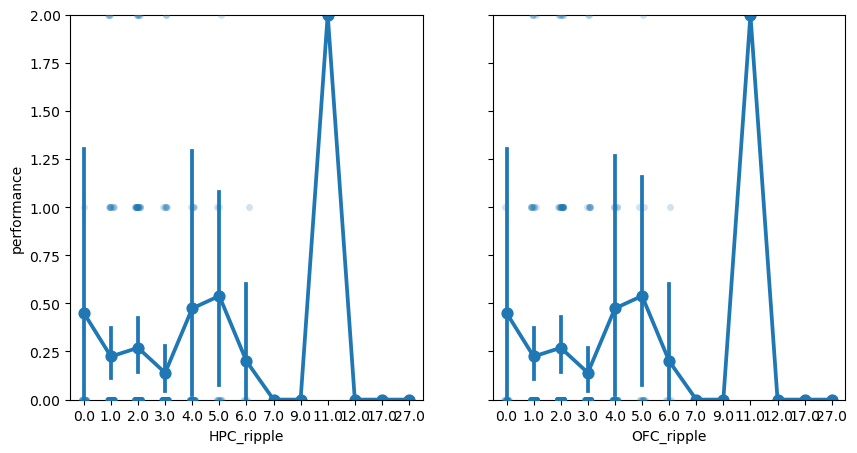

In [60]:
plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
sns.stripplot(data=all_trial_df.query('(blocktrialnumber==3) & (trialerror==0)'), 
              x='HPC_ripple',y='performance',ax=axes[0],alpha=.2)
sns.pointplot(data=all_trial_df.query('(blocktrialnumber==3) & (trialerror==0)'), 
              x='HPC_ripple',y='performance',ax=axes[0])
axes[0].set_ylim(0,2)

sns.stripplot(data=all_trial_df.query('(blocktrialnumber==3) & (trialerror==0)'), 
              x='OFC_ripple',y='performance',ax=axes[1],alpha=.2)
sns.pointplot(data=all_trial_df.query('(blocktrialnumber==3) & (trialerror==0)'), 
              x='OFC_ripple',y='performance',ax=axes[1])
axes[1].set_ylim(0,2)

Text(0.5, 0.98, 'steps actual - optimal')

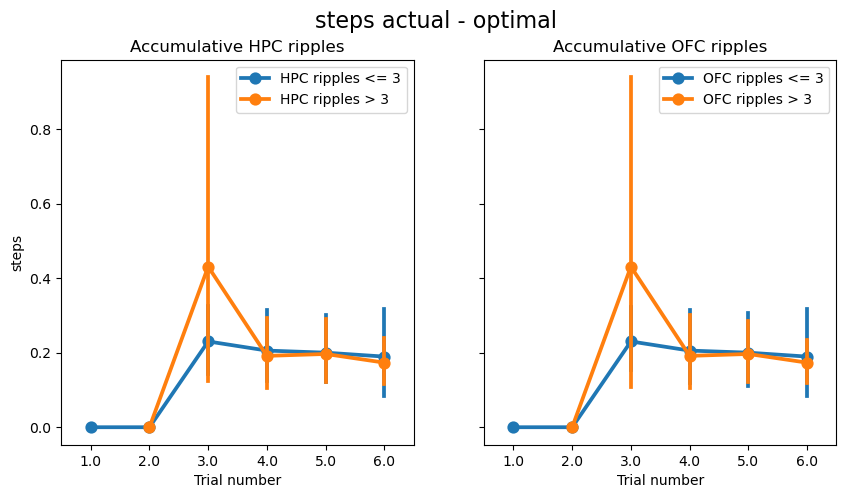

In [61]:
plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
sns.pointplot(data=all_trial_df.query('(blocktrialnumber<7) & (HPC_ripple<4)'), x='blocktrialnumber',y='performance',label='HPC ripples <= 3',ax=axes[0])
sns.pointplot(data=all_trial_df.query('(blocktrialnumber<7) & (HPC_ripple>3)'), x='blocktrialnumber',y='performance',label='HPC ripples > 3',ax=axes[0])
axes[0].set_ylabel('steps')
axes[0].set_xlabel('Trial number')
axes[0].set_title('Accumulative HPC ripples')

sns.pointplot(data=all_trial_df.query('(blocktrialnumber<7) & (OFC_ripple<4)'), x='blocktrialnumber',y='performance',label='OFC ripples <= 3',ax=axes[1])
sns.pointplot(data=all_trial_df.query('(blocktrialnumber<7) & (OFC_ripple>3)'), x='blocktrialnumber',y='performance',label='OFC ripples > 3',ax=axes[1])
axes[1].set_ylabel('steps')
axes[1].set_xlabel('Trial number')
axes[1].set_title('Accumulative OFC ripples')

plt.suptitle('steps actual - optimal',fontsize=16)
# plt.savefig('D:/SWR/performance and accumulative ripple counts, excluding current trial')

In [153]:
def plot_mean_sem(timestamps,sig,axis,ax,color,label):
    
    mean = np.nanmean(sig, axis=axis)
    std  = np.nanstd(sig, axis=axis)
    
    n = np.sum(~np.isnan(sig), axis=axis)
    sem = std / np.sqrt(n)
    
    ax.plot(timestamps, mean, color=color, label=label)
    ax.fill_between(
        timestamps,
        mean - sem,
        mean + sem,
        color=color,
        alpha=0.2
    )

In [209]:
colors = sns.color_palette('Purples_r',6)

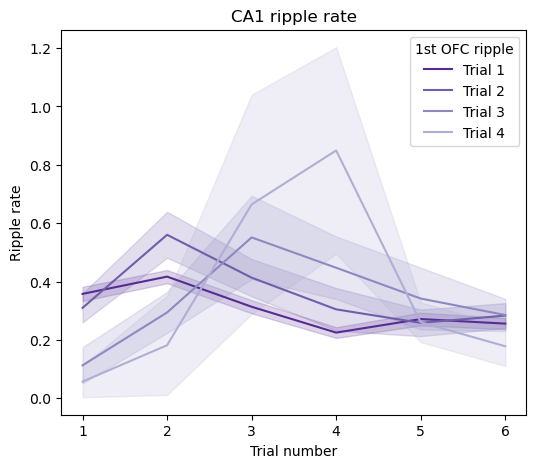

In [227]:
# keep only first_OFC = 0..4
which = 'CA1_ripples'
temp = df.dropna(subset=[which])
df_hm = temp[temp.first_OFC.isin([0, 1, 2, 3, 4])]
heatmap = np.zeros((4,6))

plt.close('all')
fig, axes = plt.subplots(figsize=(6,5))

for k in range(1,5):
    # select rows with first_OFC == k
    sub = df_hm.query('first_OFC == @k')

    if len(sub) == 0:
        continue

    # stack HPC_ripples: (n_blocks, 6)
    hpc_stack = np.vstack(sub[which].values)
    heatmap[k-1,:] = np.nanmean(hpc_stack,axis=0)
    
    plot_mean_sem(np.arange(1,7),hpc_stack,0,axes,colors[k-1],f"Trial {k}")

plt.legend(title='1st OFC ripple')
plt.ylabel('Ripple rate')
plt.xlabel('Trial number')
plt.title('%s ripple rate' % which[:3])
plt.savefig('D:/SWR/HPC OFC ripple trasfer %s' % which)

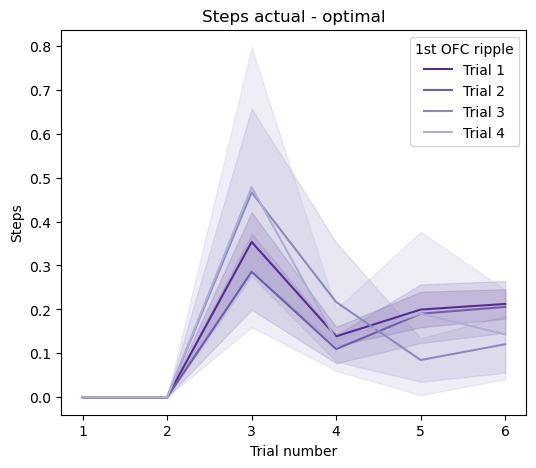

In [239]:
# keep only first_OFC = 0..4
which = 'performance'
temp = df.dropna(subset=[which])
df_hm = temp[temp.first_OFC.isin([0, 1, 2, 3, 4])]
heatmap = np.zeros((4,6))

plt.close('all')
fig, axes = plt.subplots(figsize=(6,5))

for k in range(1,5):
    # select rows with first_OFC == k
    sub = df_hm.query('first_OFC == @k')

    if len(sub) == 0:
        continue

    # stack HPC_ripples: (n_blocks, 6)
    hpc_stack = np.vstack(sub[which].values)
    heatmap[k-1,:] = np.nanmean(hpc_stack,axis=0)
    
    plot_mean_sem(np.arange(1,7),hpc_stack,0,axes,colors[k-1],f"Trial {k}")

plt.legend(title='1st OFC ripple')
plt.ylabel('Steps')
plt.xlabel('Trial number')
plt.title('Steps actual - optimal')
plt.savefig('D:/SWR/Performance OFC ripple in a block')

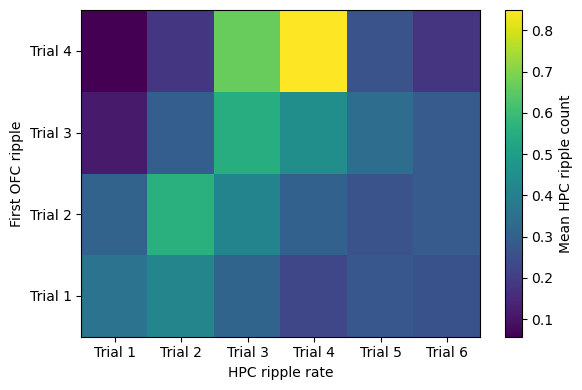

In [208]:
plt.figure(figsize=(6, 4))
im = plt.imshow(heatmap, aspect='auto', origin='lower')

plt.colorbar(im, label='Mean HPC ripple count')

plt.yticks(range(4), [f'Trial {i+1}' for i in range(4)])
plt.xticks(range(6), [f'Trial {i+1}' for i in range(6)])

plt.xlabel('HPC ripple rate')
plt.ylabel('First OFC ripple')

plt.tight_layout()
plt.show()
